In [2]:
#================== Importing modules ==============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import datetime

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder


df_train = pd.read_csv("../input/train.tsv", sep ='\t')
df_test = pd.read_csv("../input/test.tsv", sep ='\t' )


columns = ['url', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label']

Feature Engineering

In [3]:
#================== Features From Web URL ==============
def Featurize(df_train):
    U1 = df_train['url'].str.split('//',n = -1, expand = True)[1]
    U2 = U1.str.split('www.',n = -1, expand = True)[1]
    webname = U2.str.split('.',n = -1, expand = True)[0]
    U3 = U2.str.split('.',n = -1, expand = True)[1]
    domain = U3.str.split('/',n = -1, expand = True)[0]
    website_type = U3.str.split('/',n = -1, expand = True)[1]
    U4 = U3.str.split('/',n = -1, expand = True)[2]
    website_type2 = U4.str.split('/',n = -1, expand = True)[0]

    ###================= Categorical Features out of this ======
    df_train["website"] = webname
    df_train["website_type"] = website_type
    df_train["website_type2"] = website_type2
    df_train["domain"] = domain
    
    #============== Other Features ==================================
    df_train['alchemy_category_score'] = pd.to_numeric(df_train['alchemy_category_score'], errors='coerce')
    df_train["is_news"] = pd.to_numeric(df_train["is_news"], errors='coerce')
    df_train["news_front_page"] = pd.to_numeric(df_train["news_front_page"], errors='coerce')    
    
    return df_train


In [4]:
df_train = Featurize(df_train)
df_test = Featurize(df_test)

In [5]:
S1 = set(df_test['website'].value_counts()[df_test['website'].value_counts() > 0].index)
S2 = set(df_train['website'].value_counts().index)
S1 = S2.intersection(S1)
S2t = set(df_test['website'].value_counts().index)
S3 = S1 - S2

S4 = list(S2-S1)
S5 = list(S2t-S1)
len(S3)
print(S3)
df_train['website'] = df_train['website'].replace(S4, 'random')
df_test['website'] = df_test['website'].replace(S5, 'random')

set()


In [7]:
#================== Train and Test ==============
print(df_train["website"].value_counts().head())
print(df_test["website"].value_counts().head())

random            1900
insidershealth     143
huffingtonpost      99
youtube             85
ivillage            59
Name: website, dtype: int64
random            664
insidershealth     60
youtube            39
huffingtonpost     26
ivillage           24
Name: website, dtype: int64


In [8]:
S1 = set(df_test['website_type'].value_counts()[df_test['website_type'].value_counts() > 0].index)
S2 = set(df_train['website_type'].value_counts().index)
S1 = S2.intersection(S1)
S2t = set(df_test['website_type'].value_counts().index)

S3 = S1 - S2
S4 = list(S2-S1)
S5 = list(S2t-S1)
len(S3)
print(S3)
df_train['website_type'] = df_train['website_type'].replace(S4, 'random')
df_test['website_type'] = df_test['website_type'].replace(S5, 'random')

set()


In [9]:
df_train['website_type'] = df_train['website_type'].replace({'2007':'YEAR', '2008':'YEAR', 
                              '2009':'YEAR', '2010':'YEAR',
                             '2011':'YEAR', '2012':'YEAR',
                             '2013':'YEAR'})

df_test['website_type'] = df_test['website_type'].replace({'2007':'YEAR', '2008':'YEAR', 
                              '2009':'YEAR', '2010':'YEAR',
                             '2011':'YEAR', '2012':'YEAR',
                             '2013':'YEAR'})

In [11]:
S1 = set(df_test['website_type2'].value_counts()[df_test['website_type2'].value_counts() > 0].index)
S2 = set(df_train['website_type2'].value_counts().index)
S1 = S2.intersection(S1)
S2t = set(df_test['website_type2'].value_counts().index)

S3 = S1 - S2
S4 = list(S2-S1)
S5 = list(S2t-S1)
len(S3)
print(S3)
df_train['website_type2'] = df_train['website_type2'].replace(S4, 'random')
df_test['website_type2'] = df_test['website_type2'].replace(S5, 'random')

set()


In [13]:
S1 = set(df_test['domain'].value_counts()[df_test['domain'].value_counts() > 0].index)
S2 = set(df_train['domain'].value_counts().index)
S1 = S2.intersection(S1)
S2t = set(df_test['domain'].value_counts().index)

S3 = S1 - S2
S4 = list(S2-S1)
S5 = list(S2t-S1)
len(S3)
print(S3)
df_train['domain'] = df_train['domain'].replace(S4, 'random')
df_test['domain'] = df_test['domain'].replace(S5, 'random')

set()


In [15]:
columns =  [i for i in df_train.columns if i not in [ 'url','urlid', 'boilerplate', 'label']]

In [16]:
cat_variable =[]
k =0
for i in df_train[columns].dtypes:
    if(i == 'O'):
        cat_variable.append(k)    
    k =k+1

In [17]:
enc = LabelEncoder()
for i in cat_variable:
    S = set(df_train[columns[i]]) - set(df_test[columns[i]])
    print(S)
    for k in S:
        df_train[columns[i]] = df_train[columns[i]].replace([k,'<', np.nan], 'NaN')
        df_test[columns[i]] = df_test[columns[i]].replace([k,'<', np.nan], 'NaN')

{'weather', 'unknown'}
set()
set()
set()
set()


In [18]:
np.array(cat_variable)

array([ 0, 23, 24, 25, 26])

In [19]:
df_train.fillna(0, inplace = True)
df_test.fillna(0, inplace = True)

In [20]:
df_train[columns[cat_variable[3]]].head()

0     random
1    article
2     random
3         12
4          0
Name: website_type2, dtype: object

Modelling 

In [21]:
param = {  "loss_function" : "Logloss",
           "eval_metric":"AUC",
           "task_type":"GPU",
           "learning_rate":   0.07, 
           "iterations":70000,
           "l2_leaf_reg":   197, 
           "random_seed" : 432013,
           "od_type" : "Iter",
           "max_depth":   4, 
           "early_stopping_rounds" : 500,
           "border_count" :64 , 
             "bagging_temperature" :   2,   
           "task_type" : 'GPU'
        }

    
print(param)

df_train_columns = columns
cat_feature_inds =cat_variable

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()
target = df_train['label']

#================== Training the model ==============
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, target)):
    print("fold {}".format(fold_))
    X_train, y_train = df_train.iloc[trn_idx][df_train_columns], target.iloc[trn_idx]
    X_valid, y_valid = df_train.iloc[val_idx][df_train_columns], target.iloc[val_idx]
    _train = Pool(X_train, label=y_train, cat_features = cat_feature_inds)
    _valid = Pool(X_valid, label=y_valid, cat_features = cat_feature_inds)

    clf = CatBoostClassifier(**param)
    clf.fit(_train,
            eval_set=_valid,
            use_best_model=True,
            verbose=200)

    oof[val_idx] = clf.predict_proba(df_train.iloc[val_idx][df_train_columns])[:,1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict_proba(df_test[df_train_columns])[:,1] / folds.n_splits



{'loss_function': 'Logloss', 'eval_metric': 'AUC', 'task_type': 'GPU', 'learning_rate': 0.07, 'iterations': 70000, 'l2_leaf_reg': 197, 'random_seed': 432013, 'od_type': 'Iter', 'max_depth': 4, 'early_stopping_rounds': 500, 'border_count': 64, 'bagging_temperature': 2}
fold 0
0:	learn: 0.7003728	test: 0.7069435	best: 0.7069435 (0)	total: 35.7ms	remaining: 41m 37s
200:	learn: 0.7999040	test: 0.7809457	best: 0.7809457 (200)	total: 5.94s	remaining: 34m 22s
400:	learn: 0.8184756	test: 0.7847387	best: 0.7849032 (385)	total: 12.3s	remaining: 35m 27s
600:	learn: 0.8300295	test: 0.7859083	best: 0.7862262 (520)	total: 18.3s	remaining: 35m 11s
800:	learn: 0.8391967	test: 0.7863340	best: 0.7864656 (751)	total: 24.6s	remaining: 35m 24s
1000:	learn: 0.8473880	test: 0.7868512	best: 0.7869335 (993)	total: 31.6s	remaining: 36m 17s
1200:	learn: 0.8543890	test: 0.7867160	best: 0.7869335 (993)	total: 37.8s	remaining: 36m 3s
1400:	learn: 0.8616955	test: 0.7873191	best: 0.7873191 (1400)	total: 44.1s	remaini

In [22]:
#================== AUC Score ==============
CV = roc_auc_score(target, oof)
print(CV)

0.7967195254740882


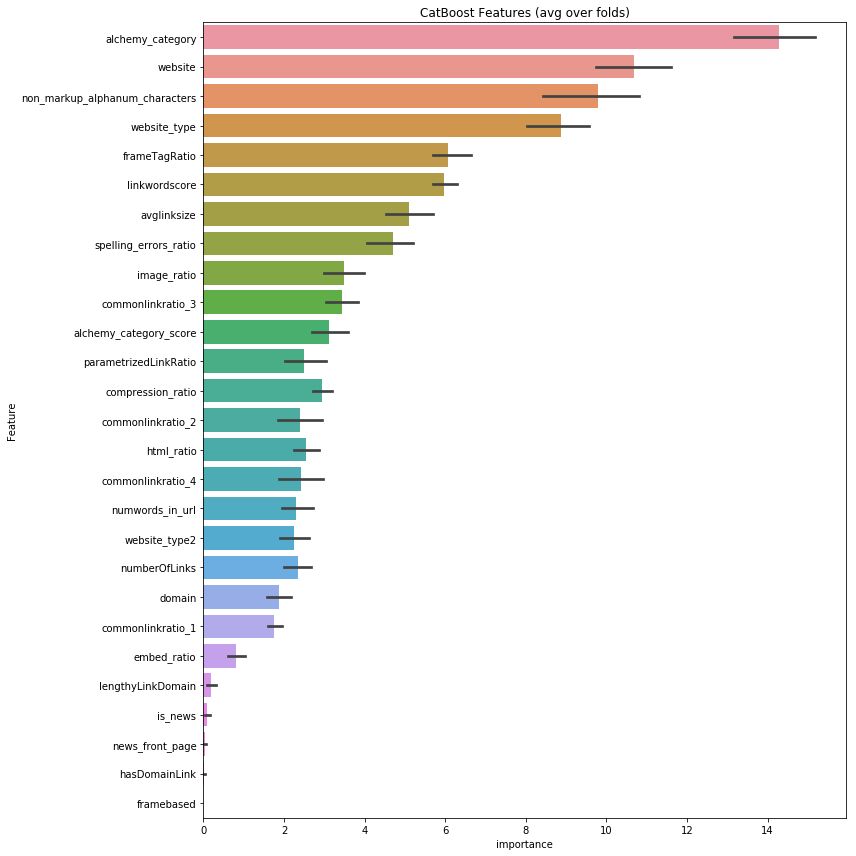

In [24]:
#================== Model Interpretability and Feature Importance ==============
for i in range(1):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:5000].index)

    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(12,12))
    sns.barplot(x="importance",
                y="Feature",
                data=best_features.sort_values(by="importance",
                                               ascending=False))
    plt.title('CatBoost Features (avg over folds)')
    plt.tight_layout()
    plt.show()


imp = best_features.groupby('Feature')['importance'].median().sort_values(ascending=False)

In [25]:
#================== Creating the submission file ==============
submission = pd.read_csv("../input/sampleSubmission.csv")
submission['label'] = predictions
submission.to_csv("submit.csv", index = False)

submission.head()

,urlid,label
0,5865,0.837482
1,782,0.343338
2,6962,0.319364
3,7640,0.086339
4,3589,0.255772
